<a href="https://colab.research.google.com/github/jfmartineb/stirlingSimulation/blob/main/Copia_de_Proyecto_Stirling_Termodin%C3%A1mica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install coolprop
!pip install pandas

In [ ]:
import CoolProp.CoolProp as cp
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

# Motor Stirling

In [ ]:
# ===========================================================================================
#                           DIMENSIONES Y DATOS DE OPERACION
# ===========================================================================================

#Propiedades 
TH = 60 + 273.15 # K
TL = 20 + 273.15 # K
P_inicial = 85.113 * 10**3 #Pa
V_total_inicial = 0.0002194312188846392 #m3
T_amb = 25 + 273.15 # K
sustancia = 'Air'
rho_inicial_sustancia = cp.PropsSI('D', 'T', T_amb, 'P', P_inicial, sustancia) # kg/m3
masa_inicial = V_total_inicial*rho_inicial_sustancia #kg

#Dimensiones maquina
D_Chamber = 0.15875 #m
H_Chamber = 0.01786 #m
D_Pinon = 0.0508 #m
D_Volante = 0.14923 #m
H_Ejechamber = 0.09543 #m

#Datos Piston
D_Cilindro = 0.015875 #m
L_PBiela = 0.060325 #m
L_PCiguenal = 0.0075 #m
th0_PCiguenal = np.pi/2

#Datos Desplazador
D_Desplazador = 0.15478 #m
H_Desplazador = 0.0075 #m
L_DBiela = 0.04763 #m
L_DCiguenal = 0.00476 #m
L_DBarra = 0.05715 #m
th0_DCiguenal = th0_PCiguenal - np.pi/2

In [ ]:
rho_inicial_sustancia_a = cp.PropsSI('D', 'T', (25+273.15), 'P', 85113, 'air') # kg/m3
masa_inicial_aire = volumen(0)*rho_inicial_sustancia_a #kg
print(masa_inicial_aire)
rho_inicial_sustancia_h = cp.PropsSI('D', 'T', (25+273.15), 'P', 85113, 'helium') # kg/m3
masa_inicial_helium = volumen(0)*rho_inicial_sustancia_h #kg
print(masa_inicial_helium)

0.0002167159098903944
2.9926684072140524e-05


In [ ]:
ECarnot = (1-(TL/TH))*100
ECarnot

12.006603631997603

In [ ]:
# ===========================================================================================
#                                        FUNCIONES
# ===========================================================================================


#Hallar Volumen total
def volumen(theta):
  th_BPiston = np.arcsin((L_PCiguenal/L_PBiela)*np.sin(theta))
  P_Piston = np.sqrt((L_PCiguenal**2)+(L_PBiela**2)-(2*L_PCiguenal*L_PBiela*np.cos(np.pi-(theta+th_BPiston))))
  volumen = (np.pi/4)*(D_Chamber**2)*(H_Chamber)+(np.pi/4)*(D_Cilindro**2)*(H_Ejechamber-P_Piston)-(np.pi/4)*(D_Desplazador**2)*(H_Desplazador)
  return volumen

#Hallar volumen abajo
def volumen_abajo(theta):
  th_BPiston = np.arcsin((L_PCiguenal/L_PBiela)*np.sin(theta))
  P_Piston = np.sqrt((L_PCiguenal**2)+(L_PBiela**2)-(2*L_PCiguenal*L_PBiela*np.cos(np.pi-(theta+th_BPiston))))
  thetad = theta - np.pi/2
  th_BDesplazador = np.arcsin((L_DCiguenal/L_DBiela)*np.sin(thetad))
  P_Desplazador = np.sqrt(L_DCiguenal**2+L_DBiela**2-2*L_DCiguenal*L_DBiela*np.cos(np.pi-(thetad+th_BDesplazador))) + L_DBarra
  V_Abajo = (np.pi/4)*(D_Chamber**2)*(H_Chamber-(H_Desplazador/2)-(P_Desplazador-H_Ejechamber))+((np.pi/4)*((D_Chamber**2)-(D_Desplazador**2))*(H_Desplazador/2))
  return V_Abajo

#Hallar volumen arriba
def volumen_arriba(theta):
  th_BPiston = np.arcsin((L_PCiguenal/L_PBiela)*np.sin(theta))
  P_Piston = np.sqrt((L_PCiguenal**2)+(L_PBiela**2)-(2*L_PCiguenal*L_PBiela*np.cos(np.pi-(theta+th_BPiston))))
  thetad = theta - np.pi/2
  th_BDesplazador = np.arcsin((L_DCiguenal/L_DBiela)*np.sin(thetad))
  P_Desplazador = np.sqrt(L_DCiguenal**2+L_DBiela**2-2*L_DCiguenal*L_DBiela*np.cos(np.pi-(thetad+th_BDesplazador))) + L_DBarra
  V_Arriba = (np.pi/4)*(((D_Chamber**2)*((P_Desplazador-H_Ejechamber)-(H_Desplazador/2)))+(D_Cilindro**2)*(H_Ejechamber-P_Piston))+((np.pi/4)*((D_Chamber**2)-(D_Desplazador**2))*(H_Desplazador/2))
  return V_Arriba

#Hallar Fuerzas e inercia 
def fuerzas(omega_inicial, th_inicial, P_ext, P_int):
  th_calc = th_inicial
  if th_calc < -np.pi:
    th_calc = th_calc+2*np.pi
  th_BPiston = np.arcsin((L_PCiguenal/L_PBiela)*np.sin(th_calc))
  F_axial = (((P_int*np.pi*D_Cilindro**2)/4) - ((P_ext*np.pi*D_Cilindro**2)/4))/np.cos(th_BPiston)
  th_tan =  np.pi - np.abs(th_BPiston) - np.abs(th_calc)
  F_tangente = F_axial*np.sin(th_tan)
  InerciaVolante = 0.5 * (0.132088) * (D_Volante/2)**2
  alpha = (F_tangente*L_PCiguenal*np.sin(th_calc))/InerciaVolante
  omega_final = omega_inicial + (alpha * dt)
  th_final = th_inicial + (omega_inicial * dt)
  return th_final, omega_final, alpha, th_BPiston, th_tan

  ## Prueba media movil ##
  def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w 


In [ ]:
#0.00021785408388004542 minimo y 0.00022082307301538232 maximo 

In [ ]:
relacion_c = 0.00022082307301538232/0.00021785408388004542
relacion_c

1.0136283382090356

# Primer Entrega


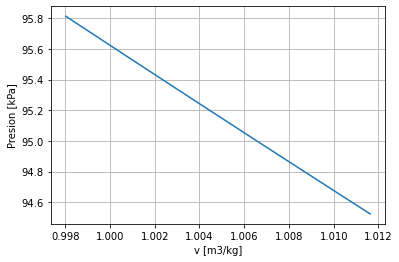

In [ ]:
#Estado 1-2
PEstado12 = []
VEstado12 = []
T_12 = TH
for n in np.arange(0 , 501*np.pi/500 , np.pi/500):
  th_12 = n
  th_BPiston = np.arcsin((L_PCiguenal/L_PBiela)*np.sin(th_12))
  P_Piston = np.sqrt((L_PCiguenal**2)+(L_PBiela**2)-(2*L_PCiguenal*L_PBiela*np.cos(np.pi-(th_12+th_BPiston))))
  V_12 = (np.pi/4)*(D_Chamber**2)*(H_Chamber)+(np.pi/4)*(D_Cilindro**2)*(H_Ejechamber-P_Piston)-(np.pi/4)*(D_Desplazador**2)*(H_Desplazador)
  D_12 = masa_inicial/V_12
  P_E1 = cp.PropsSI('P', 'T', T_12, 'D', D_12, sustancia)
  PEstado12.append(P_E1/1000)
  VEstado12.append(1/D_12)

plt.figure()

plt.plot(VEstado12,PEstado12)

plt.ylabel("Presion [kPa]")
plt.xlabel("v [m3/kg]")
plt.grid()
plt.show()



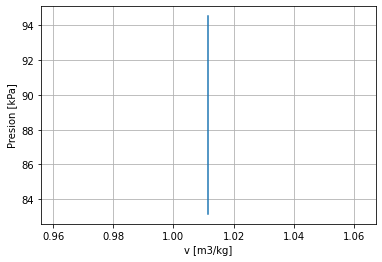

In [ ]:
#Estado 2-3
PEstado23 = []
VEstado23 = []
T_2 = TH
T_3 = TL
for t in np.arange(TH , TL-(TH-TL)/2000 , -(TH-TL)/1000):
  T_23 = t
  th_23 = np.pi
  th_BPiston = np.arcsin((L_PCiguenal/L_PBiela)*np.sin(th_23))
  P_Piston = np.sqrt((L_PCiguenal**2)+(L_PBiela**2)-(2*L_PCiguenal*L_PBiela*np.cos(np.pi-(th_23+th_BPiston))))
  V_23 = (np.pi/4)*(D_Chamber**2)*(H_Chamber)+(np.pi/4)*(D_Cilindro**2)*(H_Ejechamber-P_Piston)-(np.pi/4)*(D_Desplazador**2)*(H_Desplazador)
  D_23 = masa_inicial/V_23
  P_E2 = cp.PropsSI('P', 'T', t, 'D', D_23, sustancia)
  PEstado23.append(P_E2/1000)
  VEstado23.append(1/D_23)

#print(t23[-1])
#print(PEstado23)
#print(VEstado23[-1])               #Estos datos sirven para comprobar ciertas cosas
plt.figure()

plt.plot(VEstado23,PEstado23)

plt.ylabel("Presion [kPa]")
plt.xlabel("v [m3/kg]")
plt.grid()
plt.show()



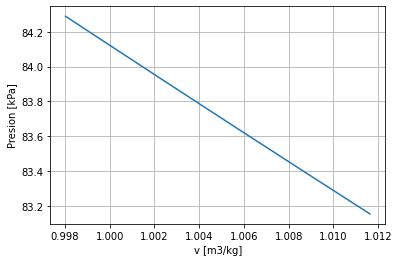

In [ ]:
#Estado 3-4
PEstado34 = []
VEstado34 = []
#angulos =[]
T_34 = TL
for ang in np.arange(np.pi , 1000.5*np.pi/500 , np.pi/500):
  #angulos.append(ang)
  th_34 = ang
  th_BPiston = np.arcsin((L_PCiguenal/L_PBiela)*np.sin(th_34))
  P_Piston = np.sqrt((L_PCiguenal**2)+(L_PBiela**2)-(2*L_PCiguenal*L_PBiela*np.cos(np.pi-(th_34+th_BPiston))))
  V_34 = (np.pi/4)*(D_Chamber**2)*(H_Chamber)+(np.pi/4)*(D_Cilindro**2)*(H_Ejechamber-P_Piston)-(np.pi/4)*(D_Desplazador**2)*(H_Desplazador)
  V_34 = volumen(ang)
  D_34 = masa_inicial/V_34
  P_E3 = cp.PropsSI('P', 'T', T_34, 'D', D_34, sustancia)
  PEstado34.append(P_E3/1000)
  VEstado34.append(1/D_34)

#print(angulos)
plt.figure()

plt.plot(VEstado34,PEstado34)

plt.ylabel("Presion [kPa]")
plt.xlabel("v [m3/kg]")
plt.grid()
plt.show()

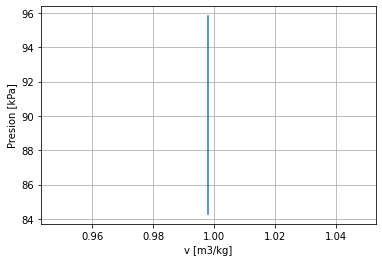

In [ ]:
#Estado 4-1
PEstado41 = []
VEstado41 = []
#T_1 = TH
#T_4 = TL
for k in np.arange(TL , TH + (TH-TL)/2000 , (TH-TL)/1000):
  T_41 = k
  th_41 = 0
  th_BPiston = np.arcsin((L_PCiguenal/L_PBiela)*np.sin(th_41))
  P_Piston = np.sqrt((L_PCiguenal**2)+(L_PBiela**2)-(2*L_PCiguenal*L_PBiela*np.cos(np.pi-(th_41+th_BPiston))))
  V_41 = (np.pi/4)*(D_Chamber**2)*(H_Chamber)+(np.pi/4)*(D_Cilindro**2)*(H_Ejechamber-P_Piston)-(np.pi/4)*(D_Desplazador**2)*(H_Desplazador)
  D_41 = masa_inicial/V_41
  P_E4 = cp.PropsSI('P', 'T', k, 'D', D_41, sustancia)
  PEstado41.append(P_E4/1000)
  VEstado41.append(1/D_41)

plt.figure()

plt.plot(VEstado41,PEstado41)

plt.ylabel("Presion [kPa]")
plt.xlabel("v [m3/kg]")
plt.grid()
plt.show()


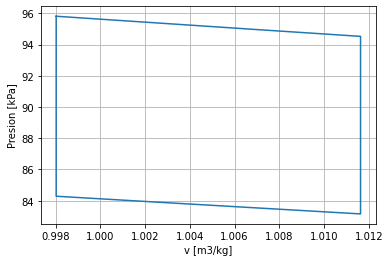

In [ ]:
#Union de los Estados y Grafica Final
VProceso = []
PProceso = []
VProceso = VEstado12 + VEstado23 + VEstado34 + VEstado41
PProceso = PEstado12 + PEstado23 + PEstado34 + PEstado41

plt.plot(VProceso,PProceso)

plt.ylabel("Presion [kPa]")
plt.xlabel("v [m3/kg]")
plt.grid()
plt.show()

In [ ]:
print(PEstado23[0])
print(PEstado23[-1])
print(VEstado12[0])
print(VEstado12[-1])

94.52460814371236
83.15548013754776
0.9980267920776172
1.01162823874173


# Segunda Entrega




In [ ]:
# ===========================================================================================
#                       PREPARACION DE VARIABLES PARA LA SIMULACION AIR
# ===========================================================================================

#Condiciones iniciales

TH = 60 + 273.15 # K
TL = 20 + 273.15 # K
P_inicial = 85.113 * 10**3 #Pa
V_total_inicial = 0.0002194312188846392 #m3
T_amb = 25 + 273.15 # K
sustancia = 'Air'
rho_inicial_sustancia = cp.PropsSI('D', 'T', T_amb, 'P', P_inicial, sustancia) # kg/m3
masa_inicial = V_total_inicial*rho_inicial_sustancia #kg

#se define tiempo y paso de simulacion

dt = 0.0001 
t = 600
t_vec = np.arange(0,t,dt)

#Inicializacion de variables

R = cp.PropsSI('GAS_CONSTANT', sustancia)/cp.PropsSI('MOLAR_MASS', sustancia)
P_ext = 85.113 * 10**3 #Pa
P_interna = P_inicial
rho_inicial = cp.PropsSI('D', 'T', T_amb, 'P', P_inicial, sustancia)

th_inicial = 0

Tf_inicial = T_amb
Tc_inicial = T_amb
Tf_actual = T_amb
Tc_actual = T_amb

V_inicial = volumen(th_inicial)
V_f_actual = volumen_arriba(th_inicial)
V_c_actual = volumen_abajo(th_inicial)
V_f_inicial = V_f_actual
V_c_inicial = V_c_actual

masa_inicial = (V_inicial)*P_interna/(R*Tf_inicial)
m_f_actual = V_f_actual*P_interna/(R*Tf_inicial)
m_c_actual = V_c_actual*P_interna/(R*Tc_inicial)
m_f_inicial = m_f_actual
m_c_inicial = m_c_actual

omega_inicial = -5*np.pi #rad/s

h_aire = 5
h_agua = 100

u_f_inicial, rho_f, Tf = cp.PropsSI(['U','D','T'], 'T', Tf_inicial, 'P', P_inicial, sustancia)
u_c_inicial, rho_c, Tc = cp.PropsSI(['U','D','T'], 'T', Tc_inicial, 'P', P_inicial, sustancia)

#Se crean los vectores de informacion 
P_vec    = np.zeros(t_vec.shape)
thtan_vec = np.zeros(t_vec.shape)
thB_vec  = np.zeros(t_vec.shape)
Tf_vec    = np.zeros(t_vec.shape)
Tc_vec    = np.zeros(t_vec.shape)
omega_vec    = np.zeros(t_vec.shape)
th_vec    = np.zeros(t_vec.shape)
uf_vec    = np.zeros(t_vec.shape)
uc_vec    = np.zeros(t_vec.shape)
vesp_vec    = np.zeros(t_vec.shape)
vel_vec  = np.zeros(t_vec.shape)
alpha_vec    = np.zeros(t_vec.shape)
sc_vec    = np.zeros(t_vec.shape)
sf_vec    = np.zeros(t_vec.shape)
x_vec    = np.zeros(t_vec.shape)
error_vec= np.zeros(t_vec.shape)
#PV = nRT 
P_actual = (masa_inicial*R)/((V_f_inicial/Tf_inicial)+(V_c_inicial/Tc_inicial))

u_f_inicial, sf_actual = cp.PropsSI(['U', 'S'], 'T', T_amb, 'P', P_actual, sustancia)
u_c_inicial, sc_actual = cp.PropsSI(['U', 'S'], 'T', T_amb, 'P', P_actual, sustancia)

#Balance de fuerzas
#P_int * A_piston - P_ext * A_piston - m_embolo * g + F_fr = m * a

#Balance de energia parte fria
#(mf_actual - mf_anterior) * hf_anterior - h_aire*A_piston*(Tf-TL)*dt - P*(Vf_actual - Vf_anterior) = mf_actual*u_actual - mf_anterior*u_anterior

#Balance de energia parte caliente
#(mc_actual - mc_anterior) * hc_anterior + h_agua*A_piston*(TH-Tc)*dt - P*(Vc_actual - Vc_anterior) = mc_actual*u_actual - mc_anterior*u_anterior

#0.0002208230730153823
#0.00021943121888463922
#85136.56696116625

In [ ]:
# ===========================================================================================
#                                    CICLO DE SIMULACION CON AIR
# ===========================================================================================
#inicial = anterior
i = 0
for t in np.arange(0,t,dt):

    if th_inicial <= -2*np.pi:
     th_inicial = th_inicial + 2*np.pi
  
    th_final, omega_final,alpha, th_BPiston, th_tan = fuerzas(omega_inicial, th_inicial, P_ext, P_actual)
    V_f_actual = volumen_arriba(th_final)
    V_c_actual = volumen_abajo(th_final)
    vesp_t = (V_f_actual+V_c_actual)/masa_inicial

    P_vec[i]   = P_actual
    Tf_vec[i]   = Tf_actual
    Tc_vec[i]   = Tc_actual
    th_vec[i]    = th_final
    thB_vec[i] = th_BPiston
    thtan_vec[i] = th_tan
    vesp_vec[i] = vesp_t
    alpha_vec[i]   = alpha
    sc_vec[i] = sc_actual
    sf_vec[i] = sf_actual
    omega_vec[i]   = omega_final
    
    P_actual = (masa_inicial*R)/((V_f_actual/Tf_inicial)+(V_c_actual/Tc_inicial))
    m_f_actual = V_f_actual*P_actual/(R*Tf_inicial)
    m_c_actual = V_c_actual*P_actual/(R*Tc_inicial)

    #Balance de energia para parte fria
    if m_f_actual-m_f_inicial < 0:
      h_inicial = cp.PropsSI('H', 'T', Tf_inicial, 'P', P_actual, sustancia)
    else: 
      h_inicial = cp.PropsSI('H', 'T', Tc_inicial, 'P', P_actual, sustancia)
    u_f_actual = (h_inicial*(m_f_actual-m_f_inicial)-(h_aire*(np.pi/4)*(D_Chamber**2-D_Cilindro**2)*(Tf_inicial-TL)*dt)-P_actual*(V_f_actual-V_f_inicial)+m_f_inicial*u_f_inicial)/m_f_actual
    Tf_actual, sf_actual = cp.PropsSI(['T', 'S'], 'U', u_f_actual, 'P', P_actual, sustancia)
    
    #Balance de energia para parte caliente
    hc_inicial = cp.PropsSI('H', 'T', Tc_inicial, 'P', P_actual, sustancia)
    u_c_actual = (h_inicial*(m_c_actual-m_c_inicial)+h_agua*(np.pi/4)*(D_Chamber**2)*(TH-Tc_inicial)*dt-P_actual*(V_c_actual-V_c_inicial)+m_c_inicial*u_c_inicial)/m_c_actual
    Tc_actual, sc_actual = cp.PropsSI(['T','S'], 'U', u_c_actual, 'P', P_actual, sustancia)

    # Se reinician las variables
    Tf_inicial = Tf_actual
    Tc_inicial = Tc_actual
    u_f_inicial = u_f_actual
    u_c_inicial = u_c_actual
    V_f_inicial = V_f_actual
    V_c_inicial = V_c_actual
    m_f_inicial = m_f_actual
    m_c_inicial = m_c_actual
    omega_inicial = omega_final
    th_inicial = th_final
    i += 1  



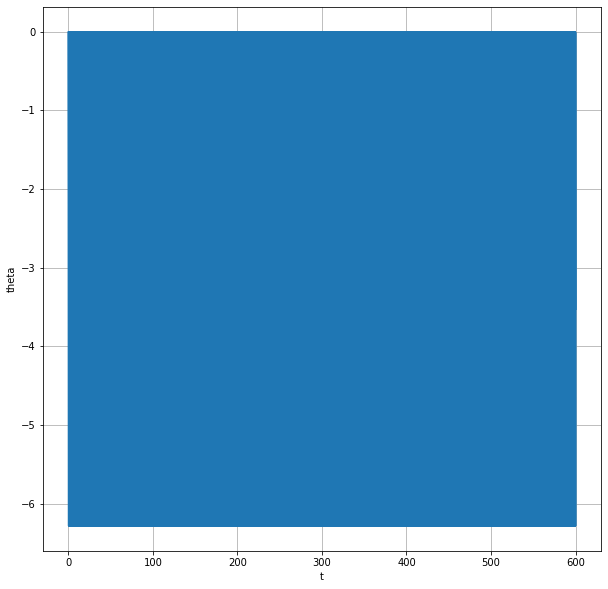

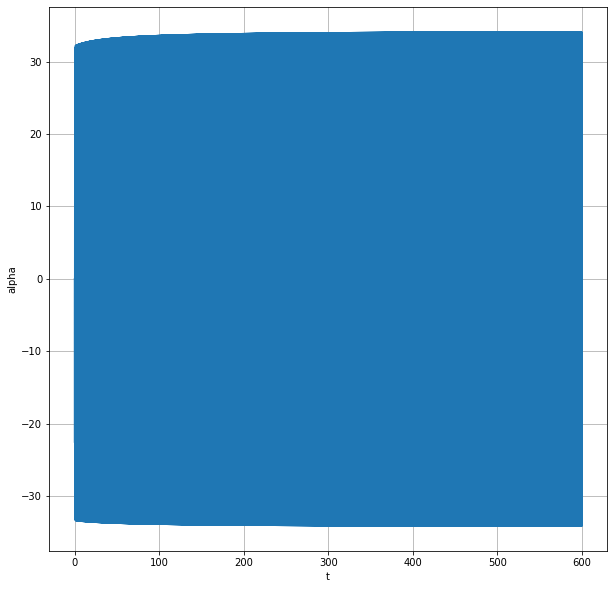

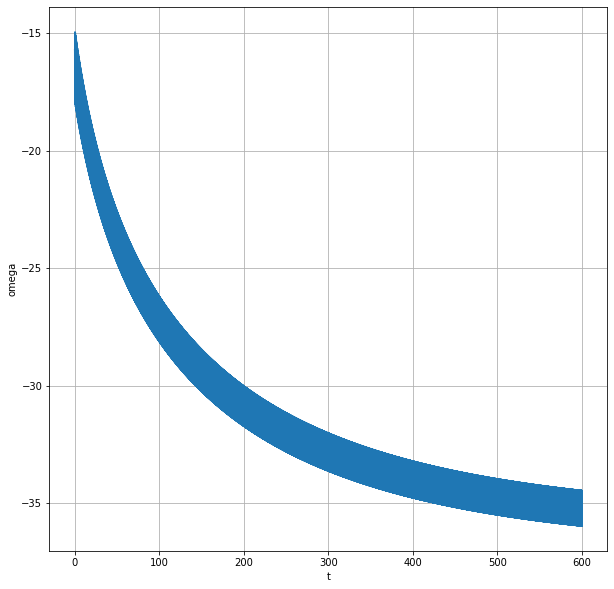

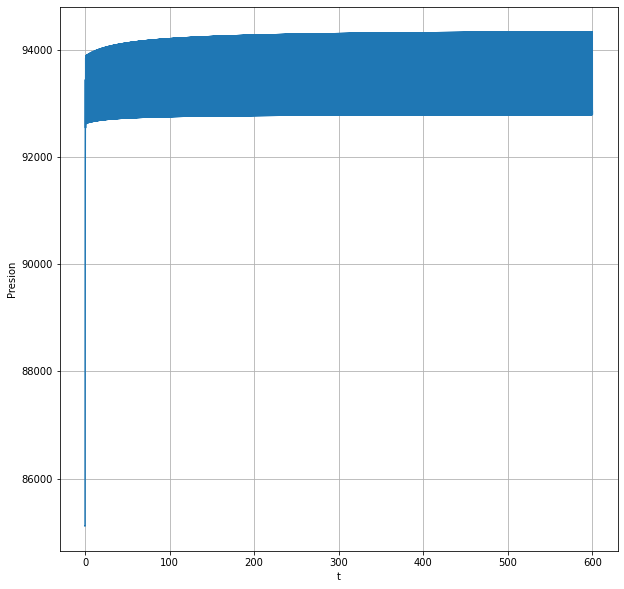

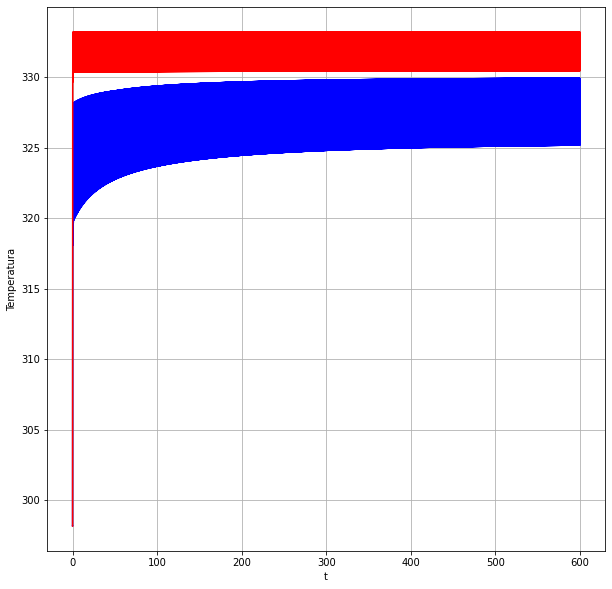

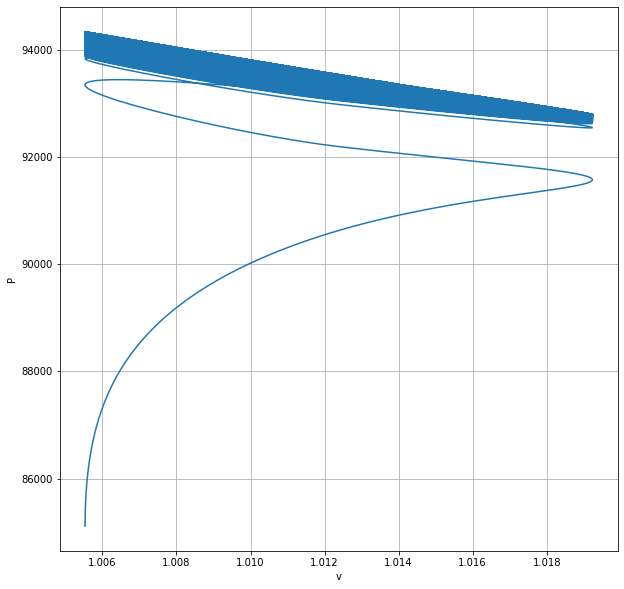

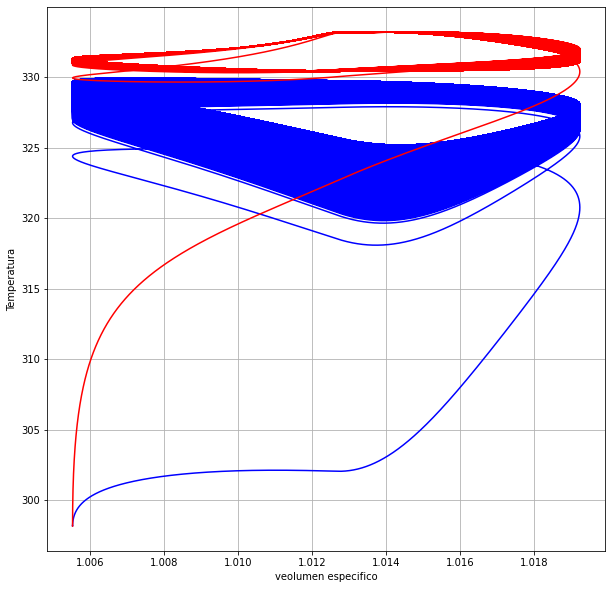

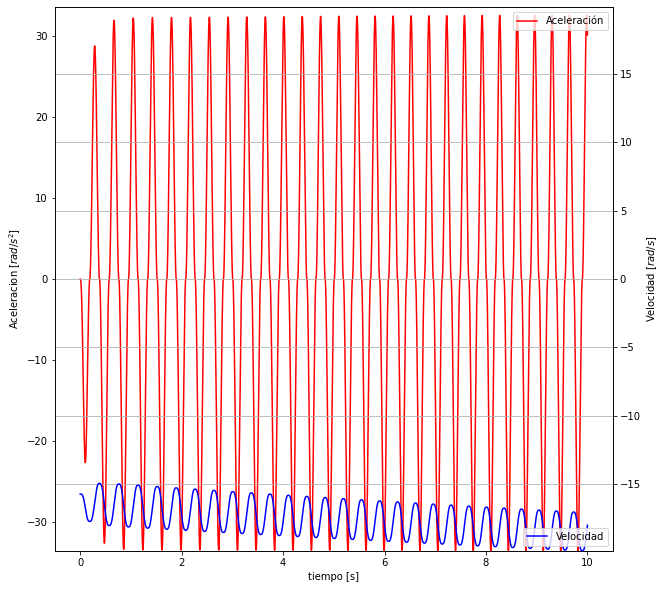

92846.40557800517
85113.0
-3.528825885240157


In [ ]:
# ===========================================================================================
#                                   GRAFICAS DE SIMULACION AIR
# ===========================================================================================
 
#Grafica del angulo theta piston
plt.figure(figsize=(10,10))

plt.plot(t_vec,th_vec)

plt.ylabel("theta")
plt.xlabel("t")
plt.grid()
plt.show()

#Grafica de aceleracion angular alpha
plt.figure(figsize=(10,10))

plt.plot(t_vec,alpha_vec)

plt.ylabel("alpha")
plt.xlabel("t")
plt.grid()
plt.show()

#Grafica de velocidad angular omega
plt.figure(figsize=(10,10))

plt.plot(t_vec,omega_vec)

plt.ylabel("omega")
plt.xlabel("t")
plt.grid()
plt.show()

#Grafica de presion en el tiempo
plt.figure(figsize=(10,10))

plt.plot(t_vec,P_vec)

plt.ylabel("Presion")
plt.xlabel("t")
plt.grid()
plt.show()

#Grafica de temperaturas en el tiempo
plt.figure(figsize=(10,10))

plt.plot(t_vec,Tf_vec,'b',label='temperatura fria')
plt.plot(t_vec,Tc_vec,'r',label='temperatura caliente')
plt.ylabel("Temperatura")
plt.xlabel("t")
plt.grid()
plt.show()

#Grafica P-v
plt.figure(figsize=(10,10))

plt.plot(vesp_vec,P_vec)

plt.ylabel("P")
plt.xlabel("v")
plt.grid()
plt.show()

#Grafica de T-v
plt.figure(figsize=(10,10))

plt.plot(vesp_vec,Tf_vec,'b')
plt.plot(vesp_vec,Tc_vec,'r')
plt.ylabel("Temperatura")
plt.xlabel("veolumen especifico")
plt.grid()
plt.show()

#Grafica de aceleracion velocidad vs tiempo
plt.figure(figsize=(10,10))

ax1 = plt.gca()

ax2 = ax1.twinx()
a_max   = max(np.abs(alpha_vec[:100000]))
vel_max = max(np.abs(omega_vec[:100000]))

indices = (t_vec<=4)
ax1.plot(t_vec[:100000], alpha_vec[:100000],'r',label = 'Aceleración')
ax2.plot(t_vec[:100000], omega_vec[:100000],'b',label = 'Velocidad')


ax1.set_ylabel("Aceleracion [$rad/s^2$]")
ax2.set_ylabel("Velocidad [$rad/s$]")
ax1.set_xlabel("tiempo [s]")
ax1.legend(loc="upper right")
ax2.legend(loc="lower right")

ax1.set_ylim(-  a_max,  a_max)
ax2.set_ylim(-vel_max,vel_max)
plt.grid()
plt.show()

print(P_actual)
print(P_ext)
print(th_final)

In [ ]:
Tf_vec.shape
dataset = pd.DataFrame({'Valores': Tf_vec})
#df = pd.DataFrame(data)

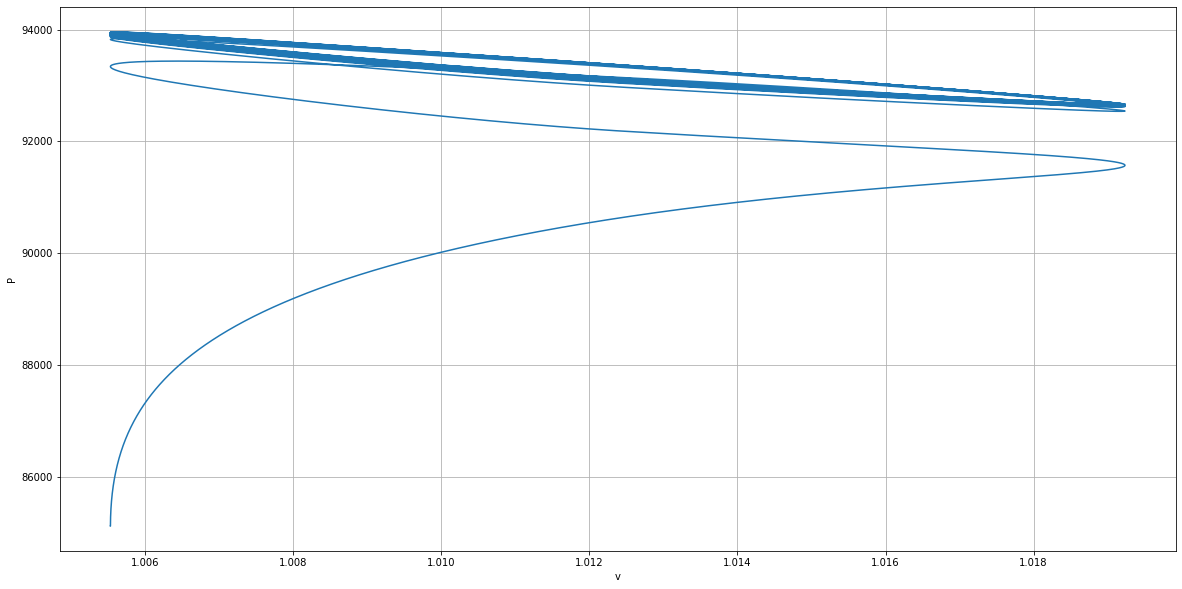

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(vesp_vec[:100000],P_vec[:100000])

plt.ylabel("P")
plt.xlabel("v")
plt.grid()
plt.show()

In [ ]:
dataset

,Valores
0,298.150000
1,298.149446
2,298.166840
3,298.177008
4,298.190023
...,...
5999995,328.601237
5999996,328.606297
5999997,328.611349
5999998,328.616393


In [ ]:
dataset['Valores_SMA_3'] = dataset.iloc[:,0].rolling(window=10).mean()

In [ ]:
MA=dataset['Valores_SMA_3'].values

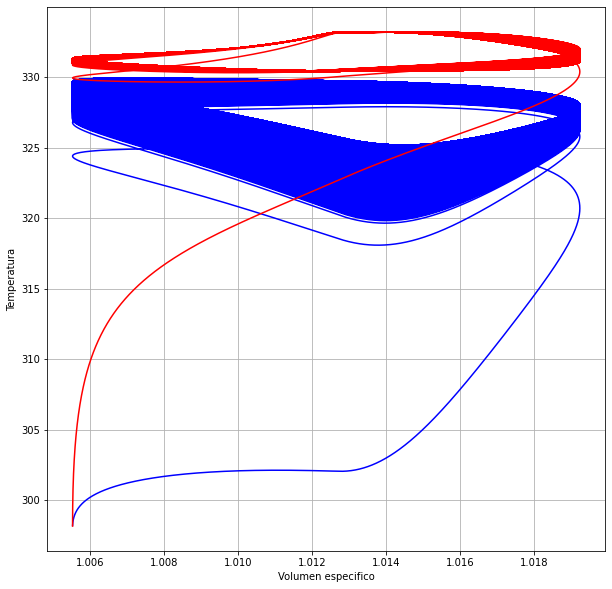

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(vesp_vec,MA,'b')
plt.plot(vesp_vec,Tc_vec,'r')
plt.ylabel("Temperatura")
plt.xlabel("Volumen especifico")
plt.grid()
plt.show()



In [ ]:
# ===========================================================================================
#                       PREPARACION DE VARIABLES PARA LA SIMULACION CON HELIUM
# ===========================================================================================

#Condiciones iniciales

TH = 60 + 273.15 # K
TL = 20 + 273.15 # K
P_inicial = 85.113 * 10**3 #Pa
V_total_inicial = 0.0002194312188846392 #m3
T_amb = 25 + 273.15 # K
sustancia = 'Helium'
rho_inicial_sustancia = cp.PropsSI('D', 'T', T_amb, 'P', P_inicial, sustancia) # kg/m3
masa_inicial = V_total_inicial*rho_inicial_sustancia #kg

#se define tiempo y paso de simulacion

dt = 0.0001 
t = 600
t_vec = np.arange(0,t,dt)

#Inicializacion de variables

R = cp.PropsSI('GAS_CONSTANT', sustancia)/cp.PropsSI('MOLAR_MASS', sustancia)
P_ext = 85.113 * 10**3 #Pa
P_interna = P_inicial
rho_inicial = cp.PropsSI('D', 'T', T_amb, 'P', P_inicial, sustancia)

th_inicial = 0

Tf_inicial = T_amb
Tc_inicial = T_amb
Tf_actual = T_amb
Tc_actual = T_amb

V_inicial = volumen(th_inicial)
V_f_actual = volumen_arriba(th_inicial)
V_c_actual = volumen_abajo(th_inicial)
V_f_inicial = V_f_actual
V_c_inicial = V_c_actual

masa_inicial = (V_inicial)*P_interna/(R*Tf_inicial)
m_f_actual = V_f_actual*P_interna/(R*Tf_inicial)
m_c_actual = V_c_actual*P_interna/(R*Tc_inicial)
m_f_inicial = m_f_actual
m_c_inicial = m_c_actual

omega_inicial = -5*np.pi #rad/s

h_aire = 5
h_agua = 100

u_f_inicial, rho_f, Tf = cp.PropsSI(['U','D','T'], 'T', Tf_inicial, 'P', P_inicial, sustancia)
u_c_inicial, rho_c, Tc = cp.PropsSI(['U','D','T'], 'T', Tc_inicial, 'P', P_inicial, sustancia)

#Se crean los vectores de informacion 
P_vec    = np.zeros(t_vec.shape)
thtan_vec = np.zeros(t_vec.shape)
thB_vec  = np.zeros(t_vec.shape)
Tf_vec    = np.zeros(t_vec.shape)
Tc_vec    = np.zeros(t_vec.shape)
omega_vec    = np.zeros(t_vec.shape)
th_vec    = np.zeros(t_vec.shape)
uf_vec    = np.zeros(t_vec.shape)
uc_vec    = np.zeros(t_vec.shape)
vesp_vec    = np.zeros(t_vec.shape)
vel_vec  = np.zeros(t_vec.shape)
alpha_vec    = np.zeros(t_vec.shape)
sc_vec    = np.zeros(t_vec.shape)
sf_vec    = np.zeros(t_vec.shape)
x_vec    = np.zeros(t_vec.shape)
error_vec= np.zeros(t_vec.shape)
#PV = nRT 
P_actual = (masa_inicial*R)/((V_f_inicial/Tf_inicial)+(V_c_inicial/Tc_inicial))

u_f_inicial, sf_actual = cp.PropsSI(['U', 'S'], 'T', T_amb, 'P', P_actual, sustancia)
u_c_inicial, sc_actual = cp.PropsSI(['U', 'S'], 'T', T_amb, 'P', P_actual, sustancia)

#Balance de fuerzas
#P_int * A_piston - P_ext * A_piston - m_embolo * g + F_fr = m * a

#Balance de energia parte fria
#(mf_actual - mf_anterior) * hf_anterior - h_aire*A_piston*(Tf-TL)*dt - P*(Vf_actual - Vf_anterior) = mf_actual*u_actual - mf_anterior*u_anterior

#Balance de energia parte caliente
#(mc_actual - mc_anterior) * hc_anterior + h_agua*A_piston*(TH-Tc)*dt - P*(Vc_actual - Vc_anterior) = mc_actual*u_actual - mc_anterior*u_anterior

#0.0002208230730153823
#0.00021943121888463922
#85136.56696116625

In [ ]:
# ===========================================================================================
#                                    CICLO DE SIMULACION CON HELIUM
# ===========================================================================================
#inicial = anterior
i = 0
for t in np.arange(0,t,dt):

    if th_inicial <= -2*np.pi:
     th_inicial = th_inicial + 2*np.pi
  
    th_final, omega_final,alpha, th_BPiston, th_tan = fuerzas(omega_inicial, th_inicial, P_ext, P_actual)
    V_f_actual = volumen_arriba(th_final)
    V_c_actual = volumen_abajo(th_final)
    vesp_t = (V_f_actual+V_c_actual)/masa_inicial

    P_vec[i]   = P_actual
    Tf_vec[i]   = Tf_actual
    Tc_vec[i]   = Tc_actual
    th_vec[i]    = th_final
    thB_vec[i] = th_BPiston
    thtan_vec[i] = th_tan
    vesp_vec[i] = vesp_t
    alpha_vec[i]   = alpha
    omega_vec[i]   = omega_final
    
    P_actual = (masa_inicial*R)/((V_f_actual/Tf_inicial)+(V_c_actual/Tc_inicial))
    m_f_actual = V_f_actual*P_actual/(R*Tf_inicial)
    m_c_actual = V_c_actual*P_actual/(R*Tc_inicial)

    #Balance de energia para parte fria
    if m_f_actual-m_f_inicial < 0:
      h_inicial = cp.PropsSI('H', 'T', Tf_inicial, 'P', P_actual, sustancia)
    else: 
      h_inicial = cp.PropsSI('H', 'T', Tc_inicial, 'P', P_actual, sustancia)
    u_f_actual = (h_inicial*(m_f_actual-m_f_inicial)-(h_aire*(np.pi/4)*(D_Chamber**2-D_Cilindro**2)*(Tf_inicial-TL)*dt)-P_actual*(V_f_actual-V_f_inicial)+m_f_inicial*u_f_inicial)/m_f_actual
    Tf_actual, sf_actual = cp.PropsSI(['T', 'S'], 'U', u_f_actual, 'P', P_actual, sustancia)
    
    #Balance de energia para parte caliente
    hc_inicial = cp.PropsSI('H', 'T', Tc_inicial, 'P', P_actual, sustancia)
    u_c_actual = (h_inicial*(m_c_actual-m_c_inicial)+h_agua*(np.pi/4)*(D_Chamber**2)*(TH-Tc_inicial)*dt-P_actual*(V_c_actual-V_c_inicial)+m_c_inicial*u_c_inicial)/m_c_actual
    Tc_actual, sc_actual = cp.PropsSI(['T','S'], 'U', u_c_actual, 'P', P_actual, sustancia)

    # Se reinician las variables
    Tf_inicial = Tf_actual
    Tc_inicial = Tc_actual
    u_f_inicial = u_f_actual
    u_c_inicial = u_c_actual
    V_f_inicial = V_f_actual
    V_c_inicial = V_c_actual
    m_f_inicial = m_f_actual
    m_c_inicial = m_c_actual
    omega_inicial = omega_final
    th_inicial = th_final
    i += 1  


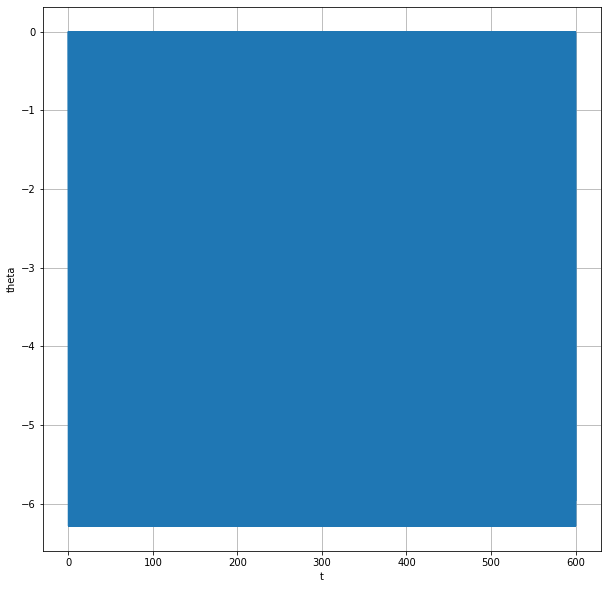

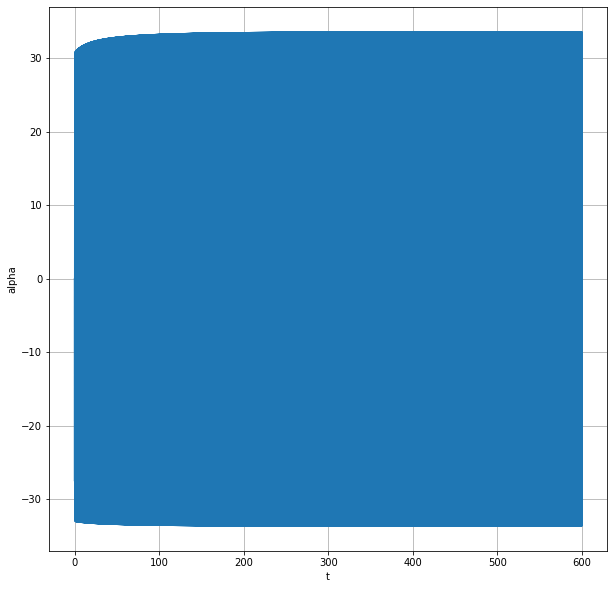

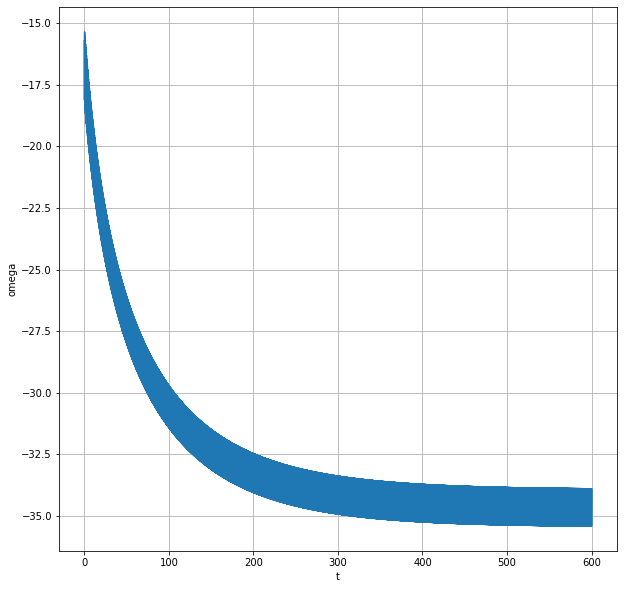

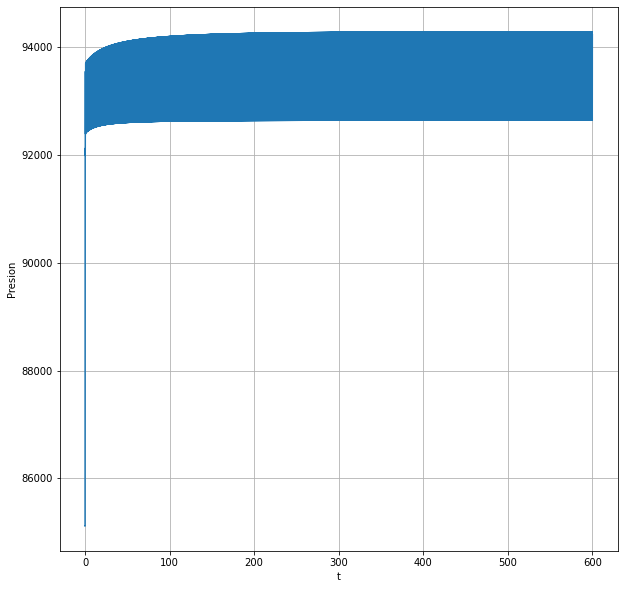

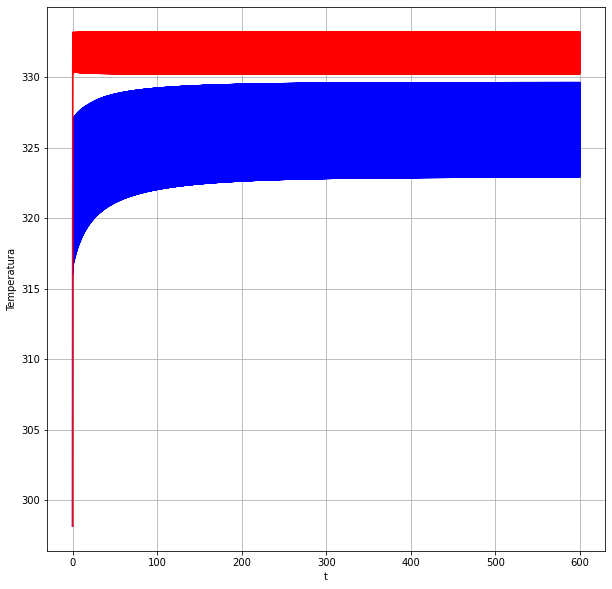

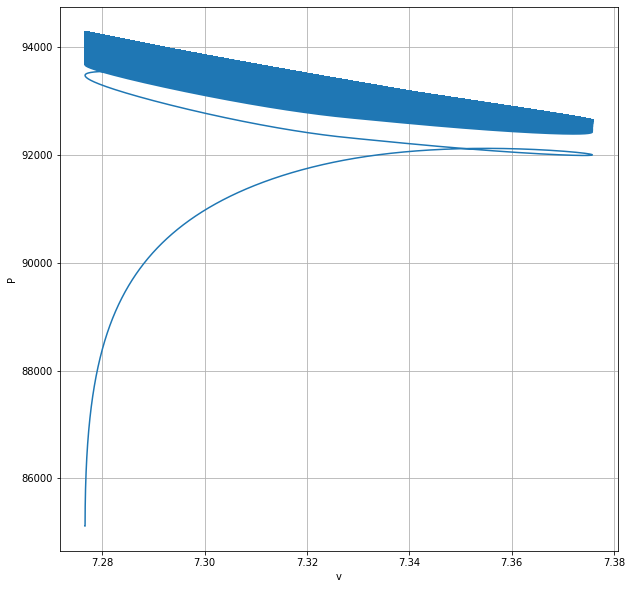

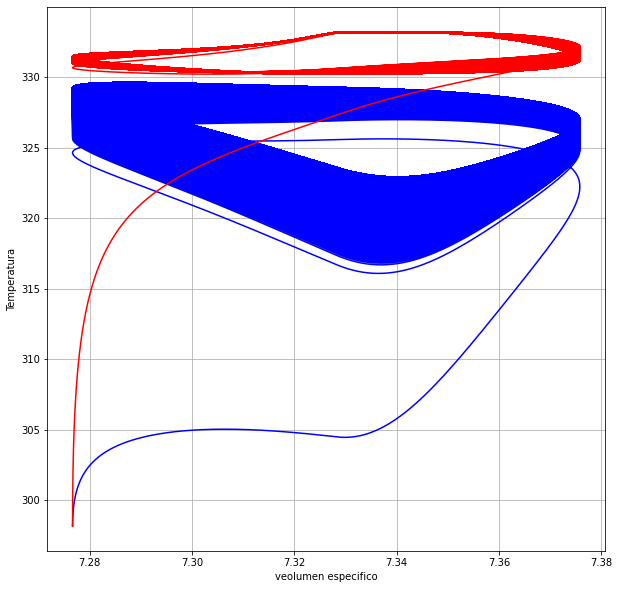

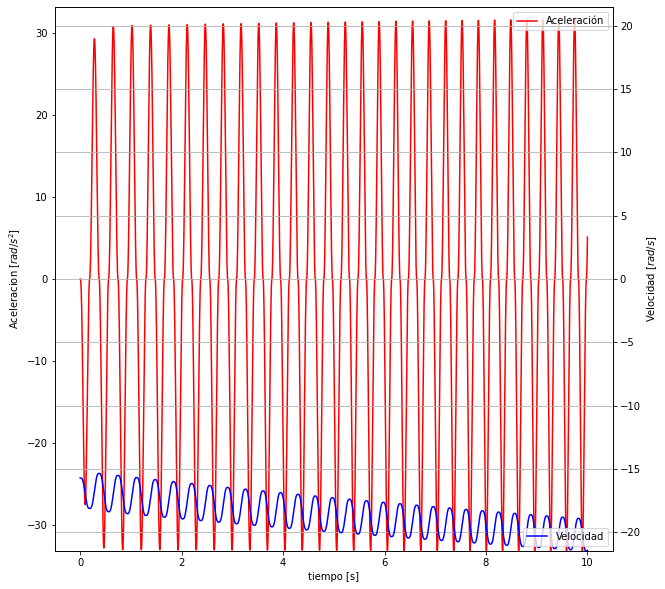

94231.98334074797
85113.0
-5.956962208067832


In [ ]:
# ===========================================================================================
#                                   GRAFICAS DE SIMULACION Helium
# ===========================================================================================
 
#Grafica del angulo theta piston
plt.figure(figsize=(10,10))

plt.plot(t_vec,th_vec)

plt.ylabel("theta")
plt.xlabel("t")
plt.grid()
plt.show()

#Grafica de aceleracion angular alpha
plt.figure(figsize=(10,10))

plt.plot(t_vec,alpha_vec)

plt.ylabel("alpha")
plt.xlabel("t")
plt.grid()
plt.show()

#Grafica de velocidad angular omega
plt.figure(figsize=(10,10))

plt.plot(t_vec,omega_vec)

plt.ylabel("omega")
plt.xlabel("t")
plt.grid()
plt.show()

#Grafica de presion en el tiempo
plt.figure(figsize=(10,10))

plt.plot(t_vec,P_vec)

plt.ylabel("Presion")
plt.xlabel("t")
plt.grid()
plt.show()

#Grafica de temperaturas en el tiempo
plt.figure(figsize=(10,10))

plt.plot(t_vec,Tf_vec,'b',label='temperatura fria')
plt.plot(t_vec,Tc_vec,'r',label='temperatura caliente')
plt.ylabel("Temperatura")
plt.xlabel("t")
plt.grid()
plt.show()

#Grafica P-v
plt.figure(figsize=(10,10))

plt.plot(vesp_vec,P_vec)

plt.ylabel("P")
plt.xlabel("v")
plt.grid()
plt.show()

#Grafica de T-v
plt.figure(figsize=(10,10))

plt.plot(vesp_vec,Tf_vec,'b')
plt.plot(vesp_vec,Tc_vec,'r')
plt.ylabel("Temperatura")
plt.xlabel("veolumen especifico")
plt.grid()
plt.show()

#Grafica de aceleracion velocidad vs tiempo
plt.figure(figsize=(10,10))

ax1 = plt.gca()

ax2 = ax1.twinx()
a_max   = max(np.abs(alpha_vec[:100000]))
vel_max = max(np.abs(omega_vec[:100000]))

indices = (t_vec<=4)
ax1.plot(t_vec[:100000], alpha_vec[:100000],'r',label = 'Aceleración')
ax2.plot(t_vec[:100000], omega_vec[:100000],'b',label = 'Velocidad')


ax1.set_ylabel("Aceleracion [$rad/s^2$]")
ax2.set_ylabel("Velocidad [$rad/s$]")
ax1.set_xlabel("tiempo [s]")
ax1.legend(loc="upper right")
ax2.legend(loc="lower right")

ax1.set_ylim(-  a_max,  a_max)
ax2.set_ylim(-vel_max,vel_max)
plt.grid()
plt.show()

print(P_actual)
print(P_ext)
print(th_final)

In [ ]:
Tf_vec.shape
dataset = pd.DataFrame({'Valores': Tf_vec})
#df = pd.DataFrame(data)

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(vesp_vec[:100000],P_vec[:100000])

plt.ylabel("P")
plt.xlabel("v")
plt.grid()
plt.show()

In [ ]:
dataset

In [ ]:
dataset['Valores_SMA_3'] = dataset.iloc[:,0].rolling(window=10).mean()

In [ ]:
MA=dataset['Valores_SMA_3'].values

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(vesp_vec,MA,'b')
plt.plot(vesp_vec,Tc_vec,'r')
plt.ylabel("Temperatura")
plt.xlabel("Volumen especifico")
plt.grid()
plt.show()


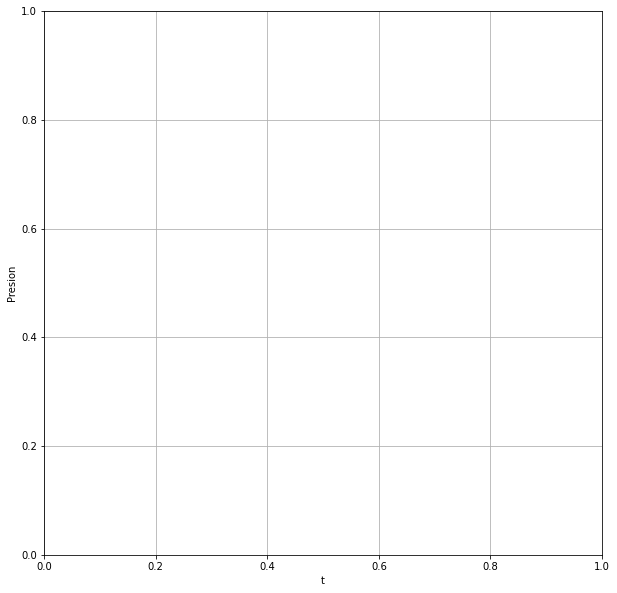

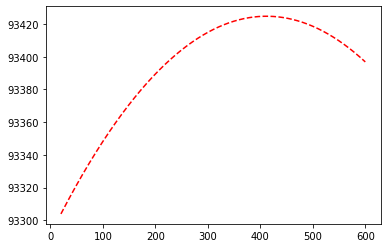

In [ ]:
#Prueba línea de tendencia

#Grafica de presion en el tiempo
plt.figure(figsize=(10,10))

plt.ylabel("Presion")
plt.xlabel("t")
plt.grid()
plt.show()
z = np.polyfit(t_vec[200000:], P_vec[200000:], 2)
p = np.poly1d(z)
plt.plot(t_vec[200000:],p(t_vec[200000:]),"r--")

In [ ]:
volmax = volumen(np.pi)
volmin = volumen(0)
print(volmax)
print(volmin)

# Codigo Profesor


In [ ]:
# Del cilindro.
D_cilindro = 0.20 # m
h_inicial  = 1.00 # m
P_inicial  = 100 * 10**3 # Pa
T_inicial  = 500 + 273.15  # K

# Del embolo:
h_embolo = 0.05 # m
rho_embolo = 7800 #kg/m^3


# Propiedades atmosféricas:
P_atm = 73760 # Pa, extraido de la tabla A-16 del libro de Çengel. 
T_out = 17 + 273.15 # K
g     = 9.81 # m/s^2

In [ ]:
A_cilindro = np.pi * (D_cilindro/2)**2 # Area del cilindro.
V_inicial  = A_cilindro * h_inicial  # Volumen inicial del cilindro


V_embolo = h_embolo * A_cilindro # Volumen del embolo
m_embolo = V_embolo * rho_embolo # Masa del embolo
mg_embolo = m_embolo * g         # Peso del embolo

In [ ]:
sustancia = 'Water'

# Extraer densidad de la sustancia:
rho_sustancia = cp.PropsSI('D', 'T', T_inicial, 'P', P_inicial, sustancia)

# Calcular la masa de la sustancia en el cilindro:
m_sustancia = rho_sustancia * V_inicial 

print("Masa inicial de sustancia: ", m_sustancia, "kg")

In [ ]:
dt = 0.001 # s : Cambio de tiempo para simulación

# Tiempo de simulación
t_simulación = 10 # segundos

# Esto crea un vector lleno de los diferentes valores de tiempo a simular,
# con un delta t definido por dt.
t_vec = np.arange(0,t_simulación,dt)

# Ahora que se tienen las condiciones iniciales, para la simulación:
P_interna  = P_inicial
P_externa  = P_atm # Constante

# Definir las condiciones iniciales de la simulación
h_embolo   = h_inicial
vel_embolo = 0 # Velocidad del embolo.
a_embolo   = 0


# Coeficiente de transferencia de calor por convección.
h_transf = 2 # [W / m2 K]

# Imponer las condiciones iniciales de la sustancia, a partir de los dos datos conocidos.
u, rho, T, P_interna, x, cv = cp.PropsSI(['U','D','T','P','Q','CVMASS'], 'T', T_inicial, 'P', P_inicial, sustancia)

# Calcular el volumen específico.
v = 1/rho

# Inicializar los vectorres como vectores llenos de ceros.

P_vec    = np.zeros(t_vec.shape)
T_vec    = np.zeros(t_vec.shape)
u_vec    = np.zeros(t_vec.shape)
v_vec    = np.zeros(t_vec.shape)
vel_vec  = np.zeros(t_vec.shape)
h_vec    = np.zeros(t_vec.shape)
a_vec    = np.zeros(t_vec.shape)
x_vec    = np.zeros(t_vec.shape)
error_vec= np.zeros(t_vec.shape)

i = 0

for t in np.arange(0,t_simulación,dt):
    
    # Extraer las condiciones del sistema:
    P_vec[i]   = P_interna
    T_vec[i]   = T
    u_vec[i]   = u
    v_vec[i]   = 1.0/rho
    vel_vec[i] = vel_embolo
    h_vec[i]   = h_embolo
    a_vec[i]   = a_embolo
    x_vec[i]   = x
    
    # ===========================================================================================
    #                               Balance de Fuerzas:
    # ===========================================================================================
    #
    # Para el pistón, el balance de fuerzas es el siguiente:
    #
    # P_int * A_int - P_ext * A_ext - m_embolo * g + F_fr = m * a
    #
    #      P_int        : Presión interna.
    #      A_int        : Area interna.
    #      P_ext        : Presión exterior.
    #      m_embolo * g : Peso del émbolo.
    #      F_fr         : Fuerza de fricción.
    #      m_sustancia  : Masa de la sustancia interna.
    #      a            : Aceleración del émbolo.
    #
    # De esta ecuación, solo se debe estimar 
    #
    

    # Fricción
    if vel_embolo > 1:
        
        F_friccion = -30
        
    elif vel_embolo < -1:
        
        F_friccion = 30
        
    else:
        
        F_friccion = - 50*vel_embolo
        
    # end if   
    
    a_embolo = ( P_interna*A_cilindro - P_externa*A_cilindro - mg_embolo + F_friccion ) / m_embolo
    
    # Actualizar posición y velocidad del embolo:
    h_embolo   = h_embolo   + vel_embolo * dt
    vel_embolo = vel_embolo +   a_embolo * dt
    
    # Recalcular volumen del cilindro:
    V_cilindro = h_embolo * A_cilindro
    
    # Calcular el cambio de volumen
    dV_cilindro = vel_embolo * dt * A_cilindro
    
    # ===========================================================================================
    #                               Balance de energía:
    # ===========================================================================================
    #
    # De manera general, el balance energético del sistema 
    # corresponde a la siguiente ecuación:
    # 
    #    E_in - E_out = dE_sistema
    #
    #    E_in - E_out = dU
    #
    #    E_in = 0 [J]
    #   
    #    E_out = Q_out + W_frontera  [J]
    #
    #      W_frontera   : Trabajo de frontera. Se toma como salida ya que el trabajo de frontera 
    #                     es positivo para un cambio de volumen positivo.
    #
    #      Q_out        : Transeferncia de calor debido a conovección.
    #
    #
    
    
    # Determinar el trabajo de frontera neto (Trabajo de salida si dV es positivo):
    W_frontera = P_interna * dV_cilindro
    
    # Transferencia de calor debida a transferencia de calor por convección
    Q_out = h_transf * A_cilindro * (T - T_out) #  W 
    
    # Determinar la energía de salida.
    E_out = Q_out*dt + W_frontera
    
    # Determinar la energía de entrada.
    E_in = 0
    
    # Calcular el cambio de energía interna:
    dU = (E_in - E_out)
    
    # Calcular la energía interna específica
    du =  dU / m_sustancia
    
    # Actualizar la energía interna.
    u_final = u + du
    
    # Recalcular el volumen específico actual de la sustancia.
    v_sustancia = V_cilindro / m_sustancia
    
    # Redefinir el las propiedades de la sustancia de acuerdo a las condiciones
    # calculadas. En este caso se redefine la energía interna u y el volumen
    # específico v (que para el caso de CoolProp debe ser con densidad:
    
    u, rho, T, P_interna, x, cv = cp.PropsSI(['U','D','T','P','Q','CVMASS'], 
                                             'U', u_final, 
                                             'D', 1.0/v_sustancia, 
                                             sustancia)
    
    
    # Actualizar el contador de iteraciones:
    i += 1
    
# end for

print("Simulación completada.")

In [ ]:
plt.figure()
plt.plot(t_vec, h_vec)

plt.ylabel("Posición émbolo [m]")
plt.xlabel("tiempo [s]")
plt.grid()
plt.show()

In [ ]:
fig,[ax1,ax2] = plt.subplots( 2, 1, sharex=True)

# Gráfica en la de arriba
ax1.plot(t_vec, P_vec/1000,'r')
ax1.set_ylabel("Presion [kPa]")

# gráfica en la de abajo
ax2.plot(t_vec, T_vec - 273.15,'k' )
ax2.set_ylabel("Temperatura [ºC]")
ax2.set_xlabel("tiempo [s]")


ax1.grid()
ax2.grid()


plt.tight_layout()
plt.show()

In [ ]:
indices = (t_vec<=4)

plt.figure()

ax1 = plt.gca()

ax2 = ax1.twinx()
a_max   = max(np.abs(  a_vec[indices]))
vel_max = max(np.abs(vel_vec[indices]))

indices = (t_vec<=4)
ax1.plot(t_vec[indices], a_vec[indices],'r',label = 'Aceleración')
ax2.plot(t_vec[indices], vel_vec[indices],'b',label = 'Velocidad')


ax1.set_ylabel("Aceleracion [$m/s^2$]")
ax2.set_ylabel("Velocidad [$m/s$]")
ax1.set_xlabel("tiempo [s]")
ax1.legend(loc="upper right")
ax2.legend(loc="lower right")

ax1.set_ylim(-  a_max,  a_max)
ax2.set_ylim(-vel_max,vel_max)
plt.grid()
plt.show()

In [ ]:
plt.figure()

plt.plot(v_vec, P_vec/1000)

plt.ylabel("Presion [kPa]")
plt.xlabel("v [m3/kg]")
plt.grid()
plt.show()

In [ ]:
# Plot the saturation line.
# +==============================

# Plot the saturated liquid line:
T0 =   1+273
T1 = 373+273
interval = 4
x = 0.0
Tf = np.zeros((T1-T0)//interval+1)
Pf = np.zeros((T1-T0)//interval+1)
vf = np.zeros((T1-T0)//interval+1)
Tg = np.zeros((T1-T0)//interval+1)
Pg = np.zeros((T1-T0)//interval+1)
vg = np.zeros((T1-T0)//interval+1)
i=0
for Ti in range(T0,T1+1,interval):
    x=0.0
    rho, P = cp.PropsSI(['D','P'], 'T', Ti, 'Q', x, sustancia)
    vf[i] = 1.0/rho
    Tf[i] = Ti
    Pf[i] = P
    
    x=1.0
    rho, P = cp.PropsSI(['D','P'], 'T', Ti, 'Q', x, sustancia)
    vg[i] = 1.0/rho
    Tg[i] = Ti
    Pg[i] = P
    
    i+=1
# end for 

plt.figure()

plt.semilogx(vf, Tf-273, 'k',label='Liq. Sat.')
plt.semilogx(vg, Tg-273, 'b',label='Vap. Sat.')
plt.semilogx(v_vec, T_vec-273,'r',label="Proceso")

plt.ylabel("Temperatura [$ºC$]")
plt.xlabel("v [$m^3/kg$]")

plt.grid()
plt.legend()
plt.show()